# Citi Bike - Most Active Station

The object is to view a half hour's worth of activity among Citi Bike stations around NYC, and determine which station was the busiest.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize
import requests
import sqlite3 as lite
import time
import datetime
from dateutil.parser import parse
import collections

#### Create a reference table for all the existing stations across the city.

In [2]:
r = requests.get('http://www.citibikenyc.com/stations/json')
ref_df = json_normalize(r.json()['stationBeanList'])
ref_df.set_index('id',inplace=True)
ref_df.head()

,altitude,availableBikes,availableDocks,city,landMark,lastCommunicationTime,latitude,location,longitude,postalCode,stAddress1,stAddress2,stationName,statusKey,statusValue,testStation,totalDocks
id,,,,,,,,,,,,,,,,,
72,,3,34,,,2016-05-31 04:37:45 PM,40.767272,,-73.993929,,W 52 St & 11 Ave,,W 52 St & 11 Ave,1,In Service,False,39
79,,27,4,,,2016-05-31 04:37:07 PM,40.719116,,-74.006667,,Franklin St & W Broadway,,Franklin St & W Broadway,1,In Service,False,33
82,,9,16,,,2016-05-31 04:34:10 PM,40.711174,,-74.000165,,St James Pl & Pearl St,,St James Pl & Pearl St,1,In Service,False,27
83,,17,42,,,2016-05-31 04:36:18 PM,40.683826,,-73.976323,,Atlantic Ave & Fort Greene Pl,,Atlantic Ave & Fort Greene Pl,1,In Service,False,62
116,,22,15,,,2016-05-31 04:37:31 PM,40.741776,,-74.001497,,W 17 St & 8 Ave,,W 17 St & 8 Ave,1,In Service,False,39


#### Create and populate a database table which will contain the number of available bikes at each station once a minute for one hour.

In [3]:
station_ids = list(ref_df.index.values)
station_ids = ['_' + str(x) + ' INT' for x in station_ids]

con = lite.connect('citi_bike.db')
cur = con.cursor()

with con:
    cur.execute("DROP TABLE IF EXISTS available_bikes;")
    cur.execute("CREATE TABLE available_bikes (execution_time INT, "\
              + ", ".join(station_ids) + ");")

In [4]:
starttime = time.time()
counter = 0

while counter < 30:
    r = requests.get('http://www.citibikenyc.com/stations/json')
    exec_time = parse(r.json()['executionTime'])
    exec_time = str((exec_time - datetime.datetime(1970,1,1)).total_seconds())
    with con:
        cur.execute('INSERT INTO available_bikes (execution_time) VALUES (?)', (exec_time,))
    id_bikes = collections.defaultdict(int)
    for station in r.json()['stationBeanList']:
        id_bikes[station['id']] = station['availableBikes']
    with con:
        for k, v in id_bikes.items():
            cur.execute("UPDATE available_bikes SET _" + str(k) +\
                        " = " + str(v) + " WHERE execution_time = " +\
                        exec_time + ";")
    print(str(counter + 1) + ' down.')
    counter += 1
    time.sleep(60.0 - ((time.time() - starttime) % 60.0))

print('Finished.')

1 down.
2 down.
3 down.
4 down.
5 down.
6 down.
7 down.
8 down.
9 down.
10 down.
11 down.
12 down.
13 down.
14 down.
15 down.
16 down.
17 down.
18 down.
19 down.
20 down.
21 down.
22 down.
23 down.
24 down.
25 down.
26 down.
27 down.
28 down.
29 down.
30 down.
Finished.


In [5]:
df = pd.read_sql_query("SELECT * FROM available_bikes ORDER BY 1",con,index_col='execution_time')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 1464712706 to 1464714447
Columns: 507 entries, _72 to _3255
dtypes: int64(507)
memory usage: 119.1 KB


In [6]:
df.head()

,_72,_79,_82,_83,_116,_119,_120,_127,_128,_137,...,_3238,_3241,_3242,_3243,_3244,_3246,_3248,_3249,_3254,_3255
execution_time,,,,,,,,,,,,,,,,,,,,,
1464712706,3,27,9,17,21,4,6,8,18,17,...,4,2,5,6,4,22,0,8,17,26
1464712768,3,27,9,17,20,4,6,8,18,16,...,4,2,5,6,3,23,0,8,17,27
1464712820,3,27,9,17,20,4,6,8,18,16,...,3,2,5,6,3,22,0,8,17,27
1464712882,3,28,9,17,20,4,6,8,18,16,...,3,2,5,6,2,22,0,8,17,27
1464712934,3,28,9,17,20,4,6,9,18,16,...,3,2,5,7,2,22,0,8,17,27


#### Determine amount of activity at each station by summing the minute by minute change, and then identify the busiest station.

In [42]:
df_deltas = df - df.shift()
hour_change = abs(df_deltas).sum().sort_values(ascending=False)
max_station = int(hour_change.first_valid_index()[1:])

In [52]:
name = ref_df.ix[max_station,12]
lat = ref_df.ix[max_station,6]
long = ref_df.ix[max_station,8]
data = (max_station, name, lat, long)

In [53]:
print('The most active station is Station ID %s at %s; Latitude: %s Longitude: %s.' % data)
print('%d bicycles came and went in the time between %s and %s.' % (
    hour_change['_'+str(max_station)],
    datetime.datetime.fromtimestamp(int(df.index[0])).strftime('%Y-%m-%dT%H:%M:%S'),
    datetime.datetime.fromtimestamp(int(df.index[-1])).strftime('%Y-%m-%dT%H:%M:%S'),
    ))

The most active station is Station ID 359 at E 47 St & Park Ave; Latitude: 40.75510267 Longitude: -73.97498696.
37 bicycles came and went in the time between 2016-05-31T12:38:26 and 2016-05-31T13:07:27.


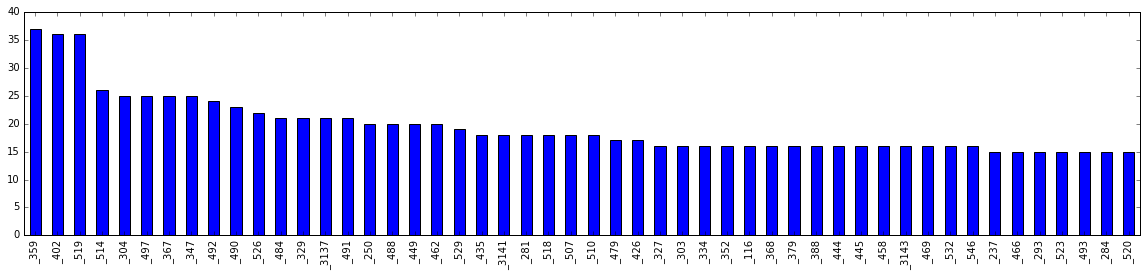

In [54]:
plt.figure(figsize=(20,4))
hour_change[:50].plot(kind='bar')